In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
from metrics import precision_at_k, recall_at_k

# warnings.filterwarnings('ignore')

In [205]:
data = pd.read_csv('02_Data/retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)
data.shape

(2396804, 12)

In [3]:
data.item_id.nunique()

89051

In [4]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [5]:
item_features = pd.read_csv('02_Data/product.csv')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

item_features.head()

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [6]:
item_features.department.unique()

array(['GROCERY', 'MISC. TRANS.', 'PASTRY', 'DRUG GM', 'MEAT-PCKGD',
       'SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI', 'COSMETICS',
       'MEAT', 'FLORAL', 'TRAVEL & LEISUR', 'SEAFOOD', 'MISC SALES TRAN',
       'SALAD BAR', 'KIOSK-GAS', 'ELECT &PLUMBING', 'GRO BAKERY',
       'GM MERCH EXP', 'FROZEN GROCERY', 'COUP/STR & MFG', 'SPIRITS',
       'GARDEN CENTER', 'TOYS', 'CHARITABLE CONT', 'RESTAURANT', 'RX',
       'PROD-WHS SALES', 'MEAT-WHSE', 'DAIRY DELI', 'CHEF SHOPPE', 'HBC',
       'DELI/SNACK BAR', 'PORK', 'AUTOMOTIVE', 'VIDEO RENTAL', ' ',
       'CNTRL/STORE SUP', 'HOUSEWARES', 'POSTAL CENTER', 'PHOTO', 'VIDEO',
       'PHARMACY SUPPLY'], dtype=object)

In [7]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [8]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [9]:
data_train.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [10]:
# Заведем фиктивный item_id

data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix)

user_item_matrix.head()

/home/foreman/anaconda3/envs/recommender_systems/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

# ALS

In [12]:
%%time
# import mkl
# mkl.set_num_threads(4)


model = AlternatingLeastSquares(factors=100,
                                regularization=0.001,
                                iterations=15,
                                calculate_training_loss=True,
                                num_threads=4)

model.fit(sparse_user_item.T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                       user_items=sparse_user_item,   # на вход user-item matrix
                       N=5, # кол-во рекомендаций 
                       filter_already_liked_items=False,
                       filter_items=None,
                       recalculate_user=True)

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 40.6 s, sys: 29.4 s, total: 1min 10s
Wall time: 6.12 s


In [13]:
recs

[(4016, 1.0817760449843314),
 (3688, 1.0493360145593333),
 (4157, 0.9977208180965899),
 (2381, 0.994636769454777),
 (3408, 0.9306748509834475)]

In [14]:
[id_to_itemid[rec[0]] for rec in recs]

[1133018, 1106523, 5569230, 999999, 1082185]

In [15]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)]
    return res

In [16]:
%%time
    
result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

CPU times: user 3min 18s, sys: 2min 58s, total: 6min 17s
Wall time: 33.4 s


0.15984329089128307

In [17]:
result.head(2)

,user_id,actual,als
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1033142, 1100972, 979707, 1056509, 995242]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1106523, 5569327, 1133018, 822407, 1044078]"


In [18]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def reduce_dims(df, dims=2, method='pca'):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        pca = PCA(n_components=dims)
        components = pca.fit_transform(df)
    elif method == 'tsne':
        tsne = TSNE(n_components=dims, learning_rate=250, random_state=42)
        components = tsne.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return pd.DataFrame(data = components, columns = colnames) 


def display_components_in_2D_space(components_df, labels='category', marker='D'):
    
    groups = components_df.groupby(labels)

    # Plot
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    for name, group in groups:
        ax.plot(group.component_1, group.component_2, 
                marker='o', ms=6,
                linestyle='',
                alpha=0.7,
                label=name)
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))

    plt.xlabel('component_1')
    plt.ylabel('component_2') 
    plt.show()

In [19]:
model.item_factors.shape

(5001, 100)

In [20]:
category = []

for idx in range(model.item_factors.shape[0]):

    try:
        cat = item_features.loc[item_features['item_id'] == id_to_itemid[idx], 'department'].values[0]
        category.append(cat)
    except:
        category.append('UNKNOWN')

In [21]:
print(category[:10])

['MISC SALES TRAN', 'KIOSK-GAS', 'MISC SALES TRAN', 'KIOSK-GAS', 'MISC SALES TRAN', 'MISC SALES TRAN', 'KIOSK-GAS', 'GROCERY', 'GROCERY', 'GROCERY']


In [22]:
%%time
item_emb_tsne = reduce_dims(model.item_factors, dims=2, method='tsne') # 5001 х 100  ---> 5001 x 2
item_emb_tsne['category'] = category  # Добавляем категорию
item_emb_tsne = item_emb_tsne[item_emb_tsne['category'] != 'UNKNOWN']
item_emb_tsne.head(2)

CPU times: user 2min 26s, sys: 1.31 s, total: 2min 27s
Wall time: 13.2 s


,component_1,component_2,category
0,0.870915,2.111935,MISC SALES TRAN
1,2.328557,-0.975347,KIOSK-GAS


Отобразим имеющиеся категории товаров на двумерную плоскость

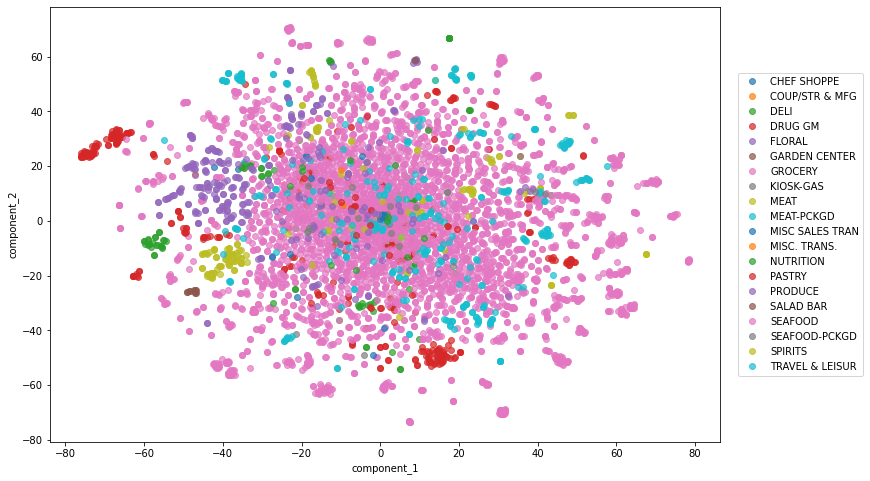

In [23]:
display_components_in_2D_space(item_emb_tsne, labels='category')

Отобразим все, кроме GROCERY

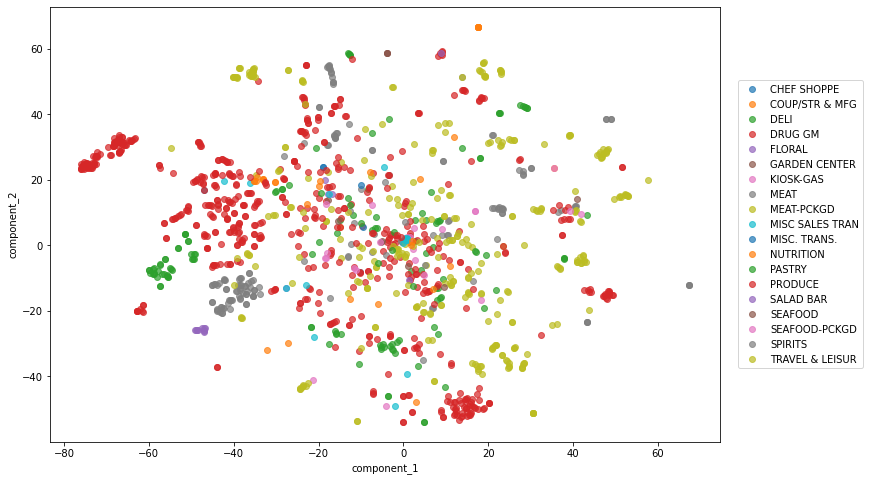

In [24]:
display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'] != 'GROCERY'], labels='category')

Отобразим несколько конкретных категорий

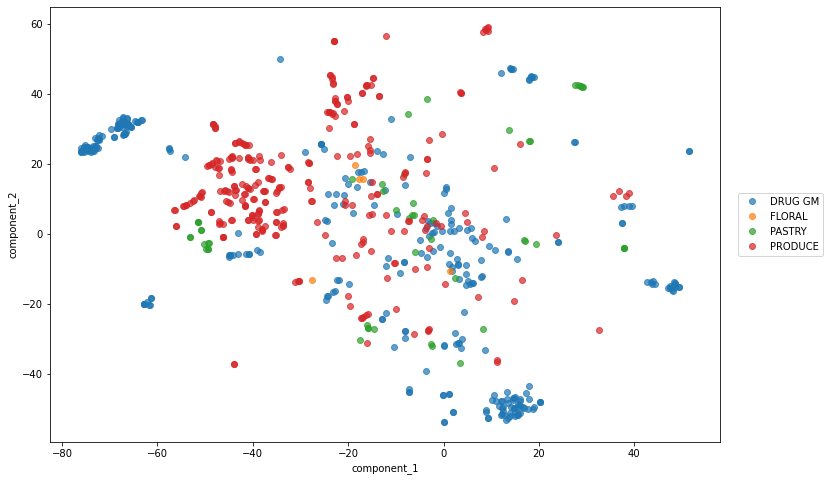

In [25]:
interesting_cats = ['PASTRY', 'PRODUCE', 'DRUG GM', 'FLORAL']

display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'].isin(interesting_cats)], 
                               labels='category')

recommend_all делает перемножение, но еще и сортирует и выбирает топ-N

In [26]:
%%time
recommendations = model.recommend_all(N=5, 
                                      user_items=sparse_user_item,
                                      filter_already_liked_items=True, 
                                      filter_items=None, 
                                      recalculate_user=True,
                                      show_progress=True,
                                      batch_size=500)

  0%|          | 0/2499 [00:00<?, ?it/s]

CPU times: user 3min 1s, sys: 3min, total: 6min 2s
Wall time: 31.4 s


In [27]:
recommendations.shape

(2499, 5)

In [28]:
recommendations

array([[3616,  832, 3359, 1927,  671],
       [2307, 2148,  215, 2757, 2316],
       [1516, 3388,  558, 3029, 1659],
       ...,
       [4346, 2148, 1349, 3587,  558],
       [ 300, 2847,  657, 2543, 1908],
       [ 558, 2434, 2454, 2216, 4060]], dtype=int32)

*Посмотрите также / Похожие товары*

In [29]:
example_item_row_id = 3606

In [30]:
id_to_itemid[example_item_row_id]

1100265

In [31]:
closest_items = [id_to_itemid[row_id] for row_id, score in model.similar_items(example_item_row_id, N=5)]

In [32]:
item_features[item_features.item_id.isin(closest_items)]

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
14959,899459,69,GROCERY,Private,CHEESE,NATURAL CHEESE EXACT WT CHUNKS,1 LB
25270,990804,69,GROCERY,Private,VEGETABLES - SHELF STABLE,MUSHROOMS CND & GLASS,4.5 OZ
32127,1051626,69,GROCERY,Private,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ
33552,1064213,972,GROCERY,National,BAG SNACKS,BAGGED POPPED POPCORN,10 OZ
37579,1100265,69,GROCERY,Private,CHEESE,NATURAL CHEESE EXACT WT SLICES,10 OZ


*Вашим друзьям нравится / Похожим пользователям нравится / ...*

Пользователь --> похожих пользовтелей --> рекомендовать те товары, которые купили похожие юзеры

In [33]:
model.similar_users(userid_to_id[10], N=5)

[(9, 1.0000001),
 (239, 0.97752446),
 (1380, 0.97510046),
 (354, 0.97458816),
 (790, 0.9740227)]

### 2. TF-IDF взвешивание

In [34]:
user_item_matrix = tfidf_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [35]:
%%time

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(sparse_user_item.T.tocsr(),  # На вход item-user matrix
          show_progress=True)

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 41.4 s, sys: 30.9 s, total: 1min 12s
Wall time: 6.48 s


In [36]:
result['als_tfidf'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

result.apply(lambda row: precision_at_k(row['als_tfidf'], row['actual']), axis=1).mean()

0.16474045053868755

### 3. BM25 взвешивание

In [37]:
user_item_matrix = bm25_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [38]:
%%time

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4) # K - кол-во билжайших соседей

model.fit(sparse_user_item.T.tocsr(),  # На вход item-user matrix
          show_progress=True)

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 39.8 s, sys: 30 s, total: 1min 9s
Wall time: 6.11 s


In [39]:
result['als_bm25'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

result.apply(lambda row: precision_at_k(row['als_bm25'], row['actual']), axis=1).mean()

0.16366307541625857

In [40]:
result.head()

,user_id,actual,als,als_tfidf,als_bm25
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1033142, 1100972, 979707, 1056509, 995242]","[1033142, 979707, 995242, 9527290, 999999]","[1033142, 979707, 986912, 5569374, 995242]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1106523, 5569327, 1133018, 822407, 1044078]","[1106523, 1133018, 5569327, 5568378, 951590]","[1106523, 1133018, 914190, 826249, 9337581]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1007195, 878996, 866211, 1023720, 986912]","[878996, 866227, 1127831, 986912, 847270]","[866211, 1007195, 878996, 1023720, 1024306]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[1058997, 938700, 999999, 1082185, 826249]","[1058997, 849843, 999999, 1126899, 1082185]","[1058997, 1126899, 999999, 1082185, 938700]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[913785, 1004906, 965766, 844179, 1068719]","[844179, 1004906, 938700, 833715, 1070820]","[1004906, 1068719, 833715, 1053690, 883404]"


In [41]:
# import os
# os.makedirs('predictions', exist_ok=True)

# result.to_csv('predictions/predictions_mf.csv', index=False)  # mf - matrix factorization

In [206]:
def prefilter_items(data):

    # исключим из данных продажи с нулевым "quantity"
    data = data[data['quantity'] >= 1]
    
    # исключим из данных продажи с нулевым "sales_value"
    data = data[data['sales_value'] > 0]
    
    popularity = data.groupby('item_id')['user_id'].nunique().reset_index()
    popularity.rename(columns={'user_id': 'share_unique_users'}, inplace=True)
    popularity['share_unique_users'] = popularity['share_unique_users'] / data['user_id'].nunique()
    
    # Уберем самые популярные товары (их и так купят), а также
    # самые НЕ популярные товары (их и так НЕ купят)
    popular = popularity[popularity['share_unique_users'].between(.03, .5)].item_id.tolist()
    data = data[~data['item_id'].isin(popular)]
    
    # Уберем товары, которые не продавались за последние 12 месяцев (последние 52 недели)
    old_item = list(set(data[data['week_no'] < data['week_no'].max() - 52].item_id.unique().tolist())\
                    - set(data[data['week_no'] >= data['week_no'].max() - 52].item_id.unique().tolist()))
    data = data[~data['item_id'].isin(old_item)] # 140 позиций
    
    # Уберем не интересные для рекоммендаций категории (department)
    # пока ничего не будем убирать    
    
#     data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))
    # Уберем слишком дешевые товары (на них не заработаем). 1 покупка из рассылок стоит 60 руб.
    # И слишком дорогие товары
    products_price = data[['item_id', 'quantity', 'sales_value']]
    products_price['price'] = products_price['sales_value'] / products_price['quantity']
    products_price = products_price.groupby('item_id')['price'].mean().reset_index()
    interest_items = products_price[products_price['price'].between(1, 150)].item_id.unique().tolist()
    data = data[data['item_id'].isin(interest_items)]
    
    # ...
    return data
    
def postfilter_items(user_id, recommednations):
    pass

In [52]:
%%time

factors_list = [100] # [50, 75, 100, 125]
regularizations_list = [.7e-01] # [.3e-02, .5e-02, .7e-02, .1e-01, .3e-01, .5e-01, .7e-01]
iterations_list = [2] #, 3, 4, 5, 6, 7, 9]

gs_result = pd.DataFrame(columns=['factors', 'regularization', 'iterations', 'mean_precision@5'])
result.drop(columns='test', inplace=True, errors='ignore')

for factor in factors_list:
    for regularization in regularizations_list:
        for iteration in iterations_list:
            model = AlternatingLeastSquares(factors=factor,
                                            regularization=regularization,
                                            iterations=iteration,
                                            calculate_training_loss=True,
                                            num_threads=4,
                                            random_state=1234)

            model.fit(sparse_user_item.T.tocsr(),  # На вход item-user matrix
                      show_progress=False)

            result['test'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

            gs_result = gs_result.append({'factors': factor,
                                          'regularization': regularization,
                                          'iterations': iteration,
                                          'mean_precision@5': result.apply(
                                              lambda row: precision_at_k(row['test'], row['actual']),
                                              axis=1
                                          ).mean()
                                         }, ignore_index=True)

CPU times: user 2min 57s, sys: 2min 54s, total: 5min 51s
Wall time: 30.6 s


In [53]:
gs_result.sort_values(by='mean_precision@5', ascending=False).head(20)

,factors,regularization,iterations,mean_precision@5
0,100.0,0.07,2.0,0.198335
